<a href="https://colab.research.google.com/github/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Twitter_Sentiment_Analysis_Model_With_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install PySastrawi==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Mengimpor library untuk preprocessing data
import pandas as pd
import numpy as np
import string
import nltk
import pickle
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for word embedding and model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# for evaluation on test data
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Membuat fungsi load_data untuk membuka file csv hasil crawling data
url= "https://github.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Dataset/Data-hasil-klasifikasi-positif-negatif.xlsx?raw=true"

In [5]:
df = pd.read_excel(url)
df.sample(10)

,tweetcreatedts,username,text,source,tweet_clean,tweet_english,klasifikasi
298,25/02/2023 19:41,nurwahidbae,kalau lihat vidio perlakuannya benar benar bia...,Twitter for Android,kalau lihat vidio perlakuannya benar benar bia...,"if you see the video of the treatment, dandy a...",Negatif
2115,28/02/2023 22:59,PerdanaKtr1995,polri bandar sabu terbesar di sumut yang dilin...,Twitter for Android,polri bandar sabu terbesar di sumut yang dilin...,the largest book of the bandar sabu bandar in ...,Positif
337,25/02/2023 11:29,tyo_tj,dulu pernah kepikiran klo jalan di daerah peru...,Twitter for Android,dulu pernah kepikiran klo jalan di daerah peru...,i used to think that if the road in this luxur...,Negatif
1849,27/02/2023 06:55,txtdarisukabumi,gacoan betul sekali orang sukabumi lebih memil...,Twitter for iPhone,gacoan betul sekali orang sukabumi lebih memil...,gacoan really sukabumi people prefer to queue ...,Positif
757,21/02/2023 04:36,terkinidotid,ini alasan jpu ajukan banding untuk ferdy samb...,dlvr.it,ini alasan jpu ajukan banding untuk ferdy samb...,this is the reason for the prosecutor to submi...,Positif
1727,24/02/2023 09:50,mediaindonesia,pj gubernur dki heru budi hartono mengungkapka...,micom,pj gubernur dki heru budi hartono mengungkapka...,acting dki governor heru budi hartono revealed...,Positif
1260,27/02/2023 19:21,bengkeldodo,tweet santai tapi yang komen sepertinya banyak...,Twitter for Android,tweet santai tapi yang komen sepertinya banyak...,"tweet relaxed, but the comments that seem to b...",Positif
2230,28/02/2023 22:23,Tinkerb50724696,polri susah ya ngeliat konpers polisi sekarang...,Twitter for Android,polri susah ya ngeliat konpers polisi sekarang...,the national police is hard to see the police ...,Negatif
276,26/02/2023 02:00,Lintas_MNCTV,polisi menetapkan satu tersangka baru kasus pe...,Twitter Media Studio,polisi menetapkan satu tersangka baru kasus pe...,the police named one new suspect in the persec...,Positif
1342,26/02/2023 07:58,kab_gerindratgl,aksi pak prabowo subianto mendingprabowo prabo...,Twitter for Android,aksi pak prabowo subianto mendingprabowo prabo...,action pak prabowo subianto mendingprrabowo pr...,Positif


In [6]:
#Menampilkan berapa banyak baris dan kolom
df.shape 

(2328, 7)

In [7]:
#Menampilkan daftar kolom, jumlah null, dan tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweetcreatedts  2328 non-null   object
 1   username        2328 non-null   object
 2   text            2328 non-null   object
 3   source          2328 non-null   object
 4   tweet_clean     2328 non-null   object
 5   tweet_english   2328 non-null   object
 6   klasifikasi     2328 non-null   object
dtypes: object(7)
memory usage: 127.4+ KB


In [8]:
# calculating missingess of entire DF
missingness = df.isnull().sum().sum() / df.count().sum()
print('Overall Missingness of df is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df).head(10)

Overall Missingness of df is: 0.00%


,Total,Percent
tweetcreatedts,0,0.0
username,0,0.0
text,0,0.0
source,0,0.0
tweet_clean,0,0.0
tweet_english,0,0.0
klasifikasi,0,0.0


In [9]:
#Hapus baris yang memiliki nilai null
df.dropna(inplace=True)

In [10]:
#Lihat duplikat data
duplCheck = df.duplicated().sum()
duplCheck

28

In [11]:
#Remove duplicate
df = df.reset_index(drop=True).drop_duplicates(subset='text', keep="last", ignore_index=True)

In [12]:
#Mneghitung jumlah klasifikasi
df["klasifikasi"].value_counts()

Positif    1225
Negatif    1069
Name: klasifikasi, dtype: int64

In [13]:
#Membuat datagrame baru yang terdiri dari kolom tweet dan klasifikasi saja
df = pd.DataFrame(df[['text', 'klasifikasi']])

### Case Folding, Menghilangkan tanda baca dan karakter yang tidak diperlukan

In [14]:
# membuat fungsi untuk case folding
def casefolding(tweet_df):
    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    pattern1 = re.compile(r'pic.twitter.com/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweet_df = re.sub(pattern,' ',tweet_df) #remove urls if any
    tweet_df = re.sub(pattern1,' ',tweet_df)
    #Convert to lower case
    tweet_df = tweet_df.lower()                                
     #Convert www.* or https?://*
    tweet_df = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet_df) 
    #Convert @username to AT_USER
    tweet_df = re.sub('@+','',tweet_df)
     #Remove additional white spaces
    tweet_df = re.sub('[\s]+', ' ', tweet_df)
    #Replace #word with word
    tweet_df  = re.sub(r'#([^\s]+)', r'\1', tweet_df )
    #remove symbols
    tweet_df = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',tweet_df)
    tweet_df = re.sub(r'[-+]?[0-9]+', '', tweet_df)  
    tweet_df = tweet_df.replace(',',' ').replace('.',' ')          
    tweet_df = re.sub(r'[^\w\s]', '', tweet_df)    
    #trim             
    tweet_df = tweet_df.strip('\'"')
    return tweet_df

### Normalisasi, Merubah kata menjadi baku

In [15]:
key_norm = pd.read_csv('https://raw.githubusercontent.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/main/Dataset/kamus-slang-ind.csv', encoding='ISO-8859-1')

def text_normalize(tweet_df):
    tweet_df = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0]
    if (key_norm['singkat'] == word).any()
    else word for word in tweet_df.split()
    ])
    tweet_df = str.lower(tweet_df)
    return tweet_df

### Stopword dan Tokenization, kata umum yang tidak memberikan informasi penting/tidak memiliki makna

In [16]:
stopwords_ind = stopwords.words('indonesian')
more_stopword = ['terusmajubersamaprabowo', 'mendingprabowo', 'prabowopresiden', 'prabowopersatuanindonesia', 'prabowosubianto']
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_word(tweet_df):
    clean_words = []
    tweet_df = tweet_df.split()
    for word in tweet_df:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)

### Stemming, berfungsi untuk menghilangkan imbuhan dan kembali ke kata dasar

In [17]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# membuat fungsi untuk stemming bahasa indonesia
def stemming(tweet_df):
    tweet_df = stemmer.stem(tweet_df)
    return tweet_df

### Text preprocessing pipeline

In [18]:
# membuat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing(tweet_df):
    tweet_df = casefolding(tweet_df)
    tweet_df = text_normalize(tweet_df)
    tweet_df = remove_stop_word(tweet_df)
    tweet_df = stemming(tweet_df)
    return tweet_df

df['text'] = df['text'].apply(text_preprocessing)

In [19]:
df.to_csv("Data-hasil-preprocessing.csv",encoding='utf-8',index=False)

### Klasifikasi Menngunakan Naive Bayes

In [20]:
newData = pd.read_csv('Data-hasil-preprocessing.csv',encoding='ISO-8859-1')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer().fit(newData['text']) 
bow_transformer.vocabulary_

In [22]:
tokens = bow_transformer.get_feature_names()
print(tokens)

['aalona', 'aan', 'aapa', 'aas', 'ab', 'abal', 'abang', 'abas', 'abby', 'abdi', 'abdul', 'abdulfickarhadjar', 'abis', 'abram', 'abu', 'abud', 'abuse', 'abw', 'acara', 'account', 'aceh', 'achika', 'achmad', 'achmadi', 'ada', 'adaapadisihite', 'adaapahariini', 'adab', 'adakan', 'adam', 'adat', 'address', 'adearysyam', 'adegan', 'adekmu', 'adik', 'adil', 'adilmakmur', 'adipala', 'admin', 'administrasi', 'adopsi', 'adu', 'adua', 'adudomba', 'aduh', 'aespastconcertsynk', 'afrizalhady', 'ag', 'aga', 'agam', 'agama', 'agen', 'agenda', 'agens', 'agh', 'agn', 'agnes', 'agnesdavid', 'agnesgracia', 'agnesgraciaharyanto', 'agnez', 'agraria', 'ags', 'agung', 'agus', 'agusharimurtiyudhoyono', 'aguskurniawan', 'agusnupatria', 'agusnurpatria', 'agusyudhoyono', 'ah', 'aha', 'aher', 'ahli', 'ahmad', 'ahmadheryawan', 'ahmadmuzani', 'ahmadoxavian', 'ahmadsyaikhu', 'ahok', 'ahyeon', 'ahypimpinperubahan', 'ai', 'aib', 'aiman', 'aimanwitjaksono', 'aimaryati', 'ainul', 'ainulyaqin', 'aipda', 'aiptu', 'air', '

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
text_bow = bow_transformer.transform(newData['text'])

In [24]:
X = text_bow.toarray()
print(X)
X.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(2294, 5689)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(text_bow)
print(tfidf_transformer)

tweet_tfidf=tfidf_transformer.transform(text_bow)
print(tweet_tfidf)
print(tweet_tfidf.shape) 

In [26]:
dd=pd.DataFrame(data=tweet_tfidf.toarray(),columns=tokens)

In [27]:
from sklearn.model_selection import train_test_split

x_latih, x_tes, y_latih, y_tes = train_test_split(X, df.klasifikasi, test_size=0.20, random_state=42)

In [28]:
print(x_latih.shape) 
print(x_tes.shape)
print(y_latih.shape)
print(y_tes.shape)

(1835, 5689)
(459, 5689)
(1835,)
(459,)


In [29]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(x_latih,y_latih)

test time:  0.038s
accuracy:   0.723
              precision    recall  f1-score   support

     Negatif       0.67      0.82      0.74       215
     Positif       0.80      0.64      0.71       244

    accuracy                           0.72       459
   macro avg       0.73      0.73      0.72       459
weighted avg       0.74      0.72      0.72       459



Text(33.0, 0.5, 'Label sebenarnya')

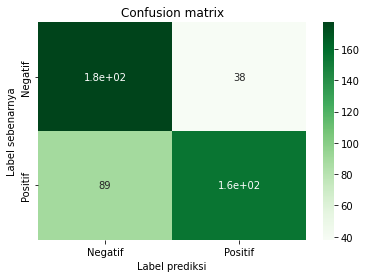

In [30]:
from time import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pandas import DataFrame

t = time()
y_pred = model.predict(x_tes)

test_time = time() - t
print("test time:  %0.3fs" % test_time)

score1 = metrics.accuracy_score(y_tes, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_tes, y_pred, target_names=['Negatif', 'Positif']))

columns = ['Negatif', 'Positif']
confm = confusion_matrix(y_tes, y_pred)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Greens', annot=True)
ax.set_title('Confusion matrix')
ax.set_xlabel('Label prediksi')
ax.set_ylabel('Label sebenarnya')

In [31]:
user_data = ["keren prabowo menang oleh suara sultra calon"]
print(user_data)

['keren prabowo menang oleh suara sultra calon']


In [32]:
test_1_unseen =  bow_transformer.transform(user_data)
data=test_1_unseen.toarray()
print("diubah menjadi array: \n ",data)

diubah menjadi array: 
  [[0 0 0 ... 0 0 0]]


In [33]:
prediction_unseen = model.predict(data)
print(prediction_unseen)

['Positif']


### Klasifikasi menggunakan LSTM

In [ ]:
file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"    
!wget $file_url

In [262]:
newDataLSTM = pd.read_csv('Data-hasil-preprocessing.csv',encoding='ISO-8859-1')

In [263]:
newDataLSTM.klasifikasi.value_counts()

Positif    1225
Negatif    1069
Name: klasifikasi, dtype: int64

In [264]:
X = newDataLSTM.text
y = newDataLSTM.klasifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

In [265]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
nunique_words = len(tokenizer.word_index) + 1
print("Number of Unique Words: {}".format(nunique_words))

Number of Unique Words: 5704


In [266]:
# saving tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [267]:
max_length = max([len(s.split()) for s in X_train])

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_length)
y_train = y_train.replace({"Negatif": 0, "Positif": 1})
y_test = y_test.replace({"Negatif": 0, "Positif": 1})

In [233]:
import gzip
embeddings_index = {}
with gzip.open('cc.id.300.vec.gz') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [268]:
# Create embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_dim = 200
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [269]:
model = tf.keras.Sequential([
    # tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [270]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32,
    validation_split=0.2,
    verbose=2)

Epoch 1/20
61/61 - 18s - loss: 0.6142 - accuracy: 0.6537 - val_loss: 0.5194 - val_accuracy: 0.7072 - 18s/epoch - 299ms/step
Epoch 2/20
61/61 - 11s - loss: 0.3948 - accuracy: 0.8184 - val_loss: 0.5655 - val_accuracy: 0.7043 - 11s/epoch - 186ms/step
Epoch 3/20
61/61 - 10s - loss: 0.2273 - accuracy: 0.9087 - val_loss: 0.6298 - val_accuracy: 0.6986 - 10s/epoch - 160ms/step
Epoch 4/20
61/61 - 11s - loss: 0.1355 - accuracy: 0.9523 - val_loss: 0.9447 - val_accuracy: 0.6928 - 11s/epoch - 180ms/step
Epoch 5/20
61/61 - 11s - loss: 0.0819 - accuracy: 0.9728 - val_loss: 0.8289 - val_accuracy: 0.6899 - 11s/epoch - 181ms/step
Epoch 6/20
61/61 - 11s - loss: 0.0404 - accuracy: 0.9877 - val_loss: 1.4967 - val_accuracy: 0.7014 - 11s/epoch - 181ms/step
Epoch 7/20
61/61 - 11s - loss: 0.0345 - accuracy: 0.9877 - val_loss: 1.7579 - val_accuracy: 0.7072 - 11s/epoch - 183ms/step
Epoch 8/20
61/61 - 11s - loss: 0.0457 - accuracy: 0.9841 - val_loss: 1.4844 - val_accuracy: 0.6986 - 11s/epoch - 183ms/step
Epoch 9/

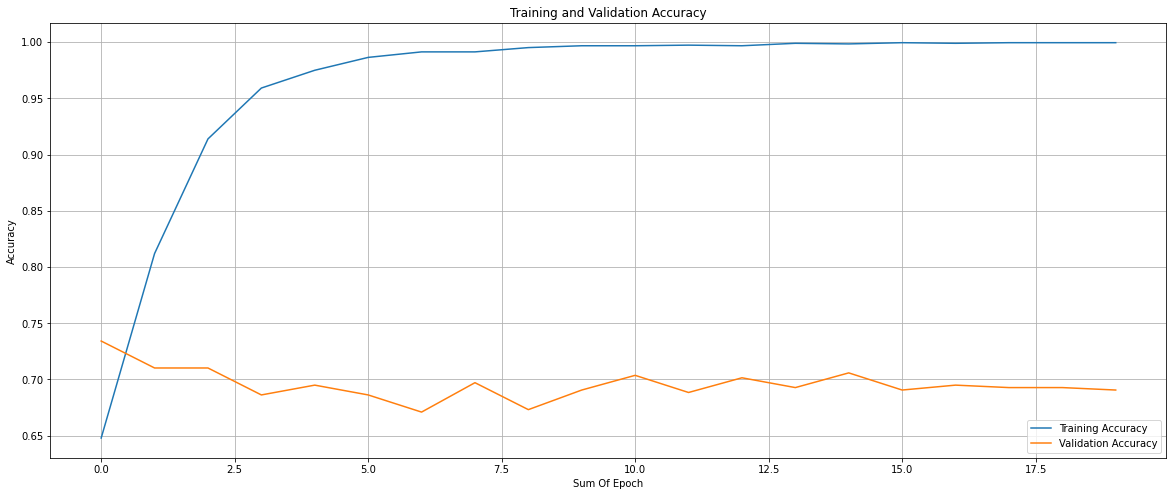

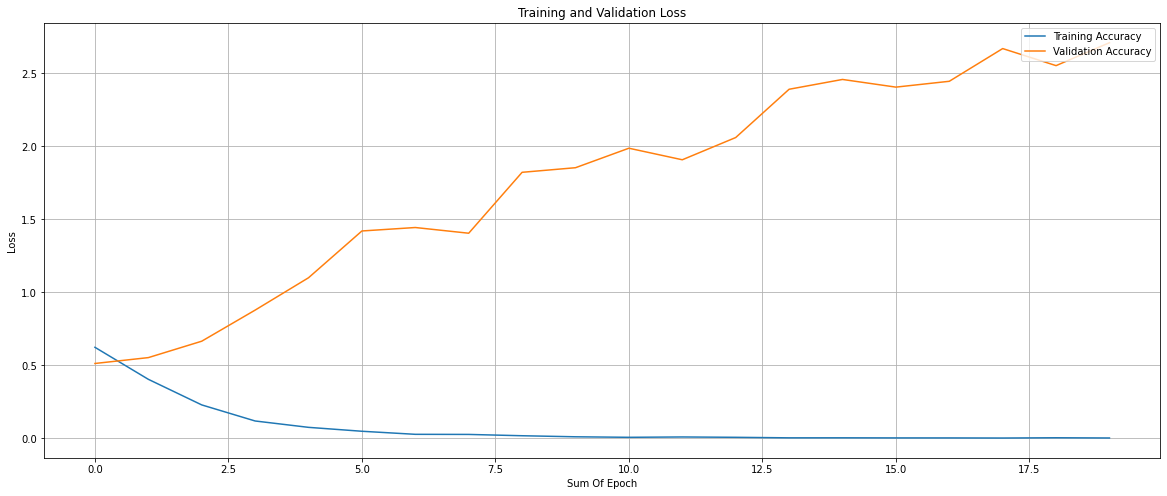

In [254]:
# Plot Training & Validation Accuracy Values
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot Training & Validation Loss Values
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()

### Evaluation on test data

In [255]:
# Evaluate
evaluate = model.evaluate(X_test, y_test, verbose=1)
print('Loss: ', evaluate[0])
print('Accuracy: ', evaluate[1]*100, ' %')

15/15 [==============================] - 0s 24ms/step - loss: 2.7108 - accuracy: 0.6906
Loss:  2.710761785507202
Accuracy:  69.06318068504333  %


In [256]:
model.save('twitter-sentiment-analysis-model-lstm.h5')

In [257]:
newmodel = load_model("twitter-sentiment-analysis-model-lstm.h5")

In [258]:
with open("/content/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

In [259]:
sequences = pad_sequences(
    tokenizer.texts_to_sequences(newDataLSTM["text"]), maxlen=X_train.shape[1]
)
score = newmodel.predict(sequences)
newDataLSTM["score"] = score
newDataLSTM["pred_klasifikasi"] = newDataLSTM["score"].apply(
    lambda x: "Positif" if x >= 0.50 else "Negatif"
)

72/72 [==============================] - 2s 24ms/step


In [260]:
accuracy_score(newDataLSTM["klasifikasi"], newDataLSTM["pred_klasifikasi"])

0.9376634699215345

In [261]:
tn, fp, fn, tp = confusion_matrix(
    newDataLSTM["klasifikasi"], newDataLSTM["pred_klasifikasi"]
).ravel()
tnr = tn / (tn + fp)
tpr = tp / (tp + fn)
print("True Negative Rate: {:.3f}".format(tnr))
print("True Positive Rate: {:.3f}".format(tpr))

True Negative Rate: 0.923
True Positive Rate: 0.950
